In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sqlite3
import folium
import geopandas as gpd

In [2]:
con = sqlite3.connect('asthma_wf.db')

In [3]:
query = '''select year,
sum(incident_acres_burned) as total_acres_burned
from wf_2 
where year != "2023"
and year >= "2009"
group by year
order by year ASC'''

In [4]:
acres = pd.read_sql_query(query, con)
acres

,year,total_acres_burned
0,2009,122.0
1,2013,496671.0
2,2014,296982.0
3,2015,412281.0
4,2016,452101.0
5,2017,1258294.0
6,2018,1529897.0
7,2019,285340.0
8,2020,2941985.0
9,2021,2292321.0


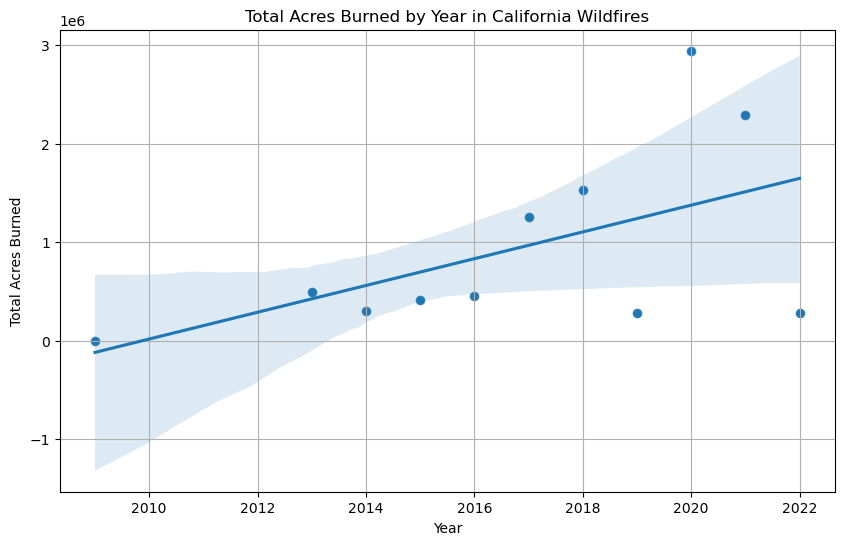

In [5]:
acres['year'] = acres['year'].astype(int)

plt.figure(figsize=(10, 6))

sns.scatterplot(data=acres, x='year', y='total_acres_burned')
sns.regplot(data=acres, x='year', y='total_acres_burned')

plt.grid()
plt.ylabel('Total Acres Burned')
plt.xlabel('Year')
plt.title('Total Acres Burned by Year in California Wildfires')

plt.show()

In [12]:
query = '''SELECT *
FROM merged
WHERE incident_county IN (
    SELECT incident_county
    FROM merged
    WHERE total_acres_burned > 50000
)
'''

In [13]:
wf_ast = pd.read_sql(query, con)

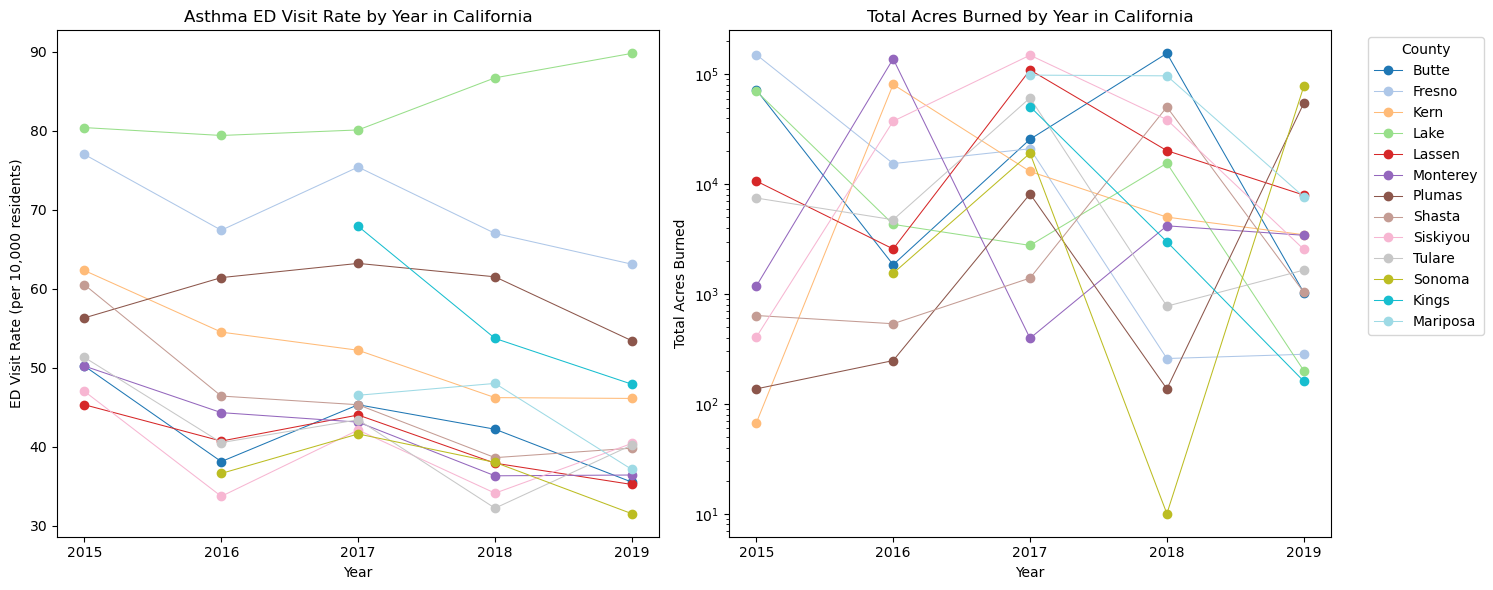

In [15]:
# make 'year' column int data type
wf_ast['year'] = wf_ast['year'].astype('int')

# assign every county a color
counties = wf_ast['incident_county'].unique()
num_counties = len(counties)
colors = plt.cm.tab20(np.linspace(0, 1, num_counties))

# create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# plot data
for county, color in zip(counties, colors):
    county_data = wf_ast[wf_ast['incident_county'] == county]
    ax[0].plot(county_data.year, county_data.visit_rate, marker='o', lw=0.75, label=county, color=color)
    ax[1].plot(county_data.year, county_data.total_acres_burned, marker='o', lw=0.75, label=county, color=color)

# set labels and title
ax[0].set_ylabel('ED Visit Rate (per 10,000 residents)')
ax[0].set_title('Asthma ED Visit Rate by Year in California')
ax[1].set_ylabel('Total Acres Burned')
ax[1].set_title('Total Acres Burned by Year in California')

for ax_ in ax:
    ax_.set_xticks(range(2015, 2020))
    ax_.set_xlabel('Year')

# set y-scale
ax[1].set_yscale("log") 

# add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='County')

plt.tight_layout()
plt.show()

In [16]:
query="select * from merged"
merged = pd.read_sql(query, con)

In [17]:
query='''select * from wf_2
where incident_acres_burned > 0'''
wf = pd.read_sql(query, con)

In [18]:
years = merged.year.unique().tolist()

# create map for every year - iterate through every year
for year in years:
    
    merged_year = merged[merged['year'] == year]
    
    # read the county shapefile
    counties_shapefile = "CA_Counties/CA_Counties_TIGER2016.shp"
    counties_gdf = gpd.read_file(counties_shapefile)

    # merge data with the county shapefile based on county name
    merged_counties = counties_gdf.merge(merged_year, left_on='NAME', right_on='incident_county')

    # create a Folium map object and set its initial location
    map = folium.Map(location=[37.25, -119.5], zoom_start=6)
    
    # add title
    title_html = '''
        <h3 style="text-align: center;"><strong>Average Asthma Visit ED Rate vs. Wildfires in California</strong></h3>
        <h4 style="text-align: center;"><strong>{year}</strong></h4>
    '''
    
    map.get_root().html.add_child(folium.Element(title_html.format(year=year)))

    # add choropleth layer to the map
    folium.Choropleth(
        geo_data=merged_counties,
        name='choropleth',
        data=merged_counties,
        columns=['NAME', 'visit_rate'],
        key_on='feature.properties.NAME',
        fill_color='YlOrRd',  # Change the fill color to purple
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Average Asthma ED Rate (per 10,000 residents)'
    ).add_to(map)
    
    # define CA state boundaries
    lat_min, lat_max = 32, 43 
    lon_min, lon_max = -125, -115
    
    # filter data for current year and wildfires incidents with coordinates within CA state boundaries 
    wf_year = wf[wf['year'] == year]
    wf_year = wf_year[(wf_year['incident_latitude'] > lat_min) & (wf_year['incident_latitude'] < lat_max)]
    wf_year = wf_year[(wf_year['incident_longitude'] > lon_min) & (wf_year['incident_longitude'] < lon_max)]
    
    # add circle marker for overlaying total_acres_burned for every wildfire incident
    for idx, row in wf_year.iterrows():
        lat = row['incident_latitude']
        lon = row['incident_longitude']
        acres = row['incident_acres_burned']
        radius = acres / 10000  # Adjust the scaling factor as needed
        color = 'red'  # Set the color of the marker to purple

        # Create a popup content string with county information and total acres burned for every marker
        popup_content = f"County: {row['incident_county']}<br>"
        popup_content += f"Total Acres Burned: {acres}"

        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            color=color,
            fill=True,
            fill_color=color,
            popup=popup_content 
        ).add_to(map)

    # add a layer control 
    folium.LayerControl().add_to(map)

    map.save(f'map_{year}.html')

In [47]:
query = '''select year, 
sum(num_visits) as yearly_visits
from merged
group by year'''

In [48]:
visits_per_year = pd.read_sql(query, con)
visits_per_year

,year,yearly_visits
0,2015,156743.0
1,2016,165284.0
2,2017,168880.0
3,2018,157044.0
4,2019,149766.0


In [49]:
query='''select year,
sum(incident_acres_burned) as total_acres_burned
from wf_2 
where year != "2023"
	and year >= "2015"
    and year <= "2019"
group by year'''

In [50]:
wf_per_year = pd.read_sql(query, con)
wf_per_year

,year,total_acres_burned
0,2015,412281.0
1,2016,452101.0
2,2017,1258294.0
3,2018,1529897.0
4,2019,285340.0


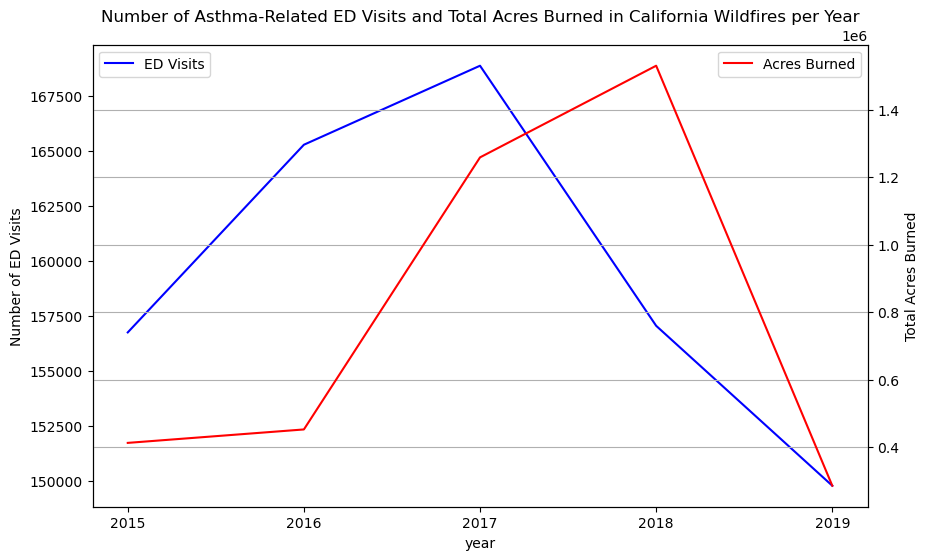

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()

sns.lineplot(data=visits_per_year, x='year', y='yearly_visits', c='blue', ax=ax, label='ED Visits')
sns.lineplot(data=wf_per_year, x='year', y='total_acres_burned', c='red', ax=ax2, label='Acres Burned')

ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.grid()
ax.set_ylabel('Number of ED Visits')
ax2.set_ylabel('Total Acres Burned')
plt.xlabel('Year')
plt.title('Number of Asthma-Related ED Visits and Total Acres Burned in California Wildfires per Year')

plt.show()